In [1]:
import os
from pathlib import Path
import random
import torch
import glob
from shutil import copyfile
import torch.nn as nn
import torchinfo
from torchinfo import summary

In [2]:
from engine import train
from data_preparation import *
from utils import *
from dataloaders import create_dataloaders
from allResNets import *

In [3]:
#Change disk directory
base_path = Path("G:/Dissertation/")
if(Path().cwd() != Path(r"G:\Dissertation")):
    os.chdir(base_path)

In [4]:
dataset_path = Path('dataset/')
data_dir = Path("split_1k/")
split_size = [0.8,0.1,0.1]

#split_data(dataset_path, data_dir, split_size, num_img_class=10000)

In [5]:
from torchvision import transforms
#Create transform (in this case for the ResNet images are resized to 224x224 and transformed into Tensors)
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(224, 224)),
  # Flip the images randomly on the horizontal (just to make it as independent from the position of the pipeline)
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() 
])

In [6]:
#Paths criados pelo split_data
train_dir = data_dir / Path('train/')
validation_dir = data_dir / Path('validation/')
test_dir = data_dir / Path('test/')

BATCH_SIZE = 32 

train_dataloader, validation_dataloader, test_dataloader, class_names, train_data, validation_data, test_data = create_dataloaders(train_dir = train_dir,
                                                                                                                                   test_dir = test_dir,
                                                                                                                                   validation_dir = validation_dir,
                                                                                                                                   transform = data_transform,
                                                                                                                                   batch_size = BATCH_SIZE)

In [8]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))

In [9]:
# Set number of epochs
NUM_EPOCHS = 5

device = get_device()
model = ResNet18().to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model
model_results = train(model=model,
                    train_dataloader=train_dataloader,
                    validation_dataloader=validation_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1234 | train_acc: 0.4915 | validation_loss: 0.9277 | validation_acc: 0.7391
Epoch: 2 | train_loss: 0.7243 | train_acc: 0.7622 | validation_loss: 0.5781 | validation_acc: 0.8141
Epoch: 3 | train_loss: 0.5430 | train_acc: 0.7980 | validation_loss: 0.4446 | validation_acc: 0.8336
Epoch: 4 | train_loss: 0.4656 | train_acc: 0.8205 | validation_loss: 0.4316 | validation_acc: 0.8516
Epoch: 5 | train_loss: 0.4226 | train_acc: 0.8333 | validation_loss: 0.3746 | validation_acc: 0.8688
Total training time: 454.644 seconds


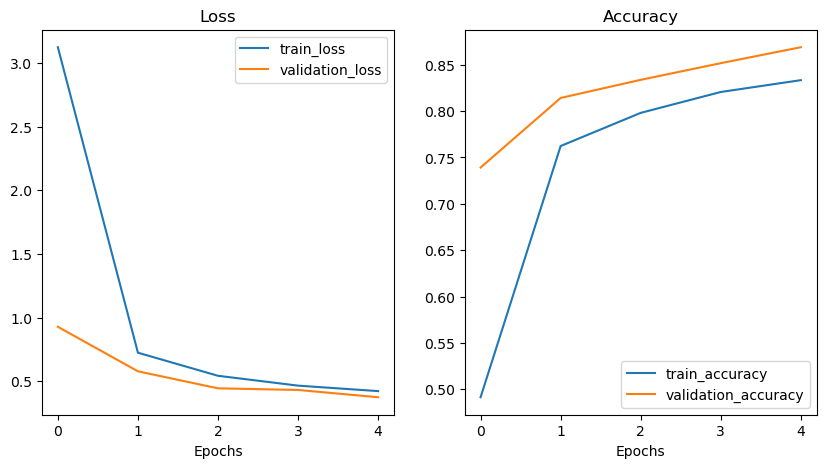

In [10]:
plot_loss_curves(model_results)

<function utils.plot_confusion_matrix(labels, pred_labels, classes)>

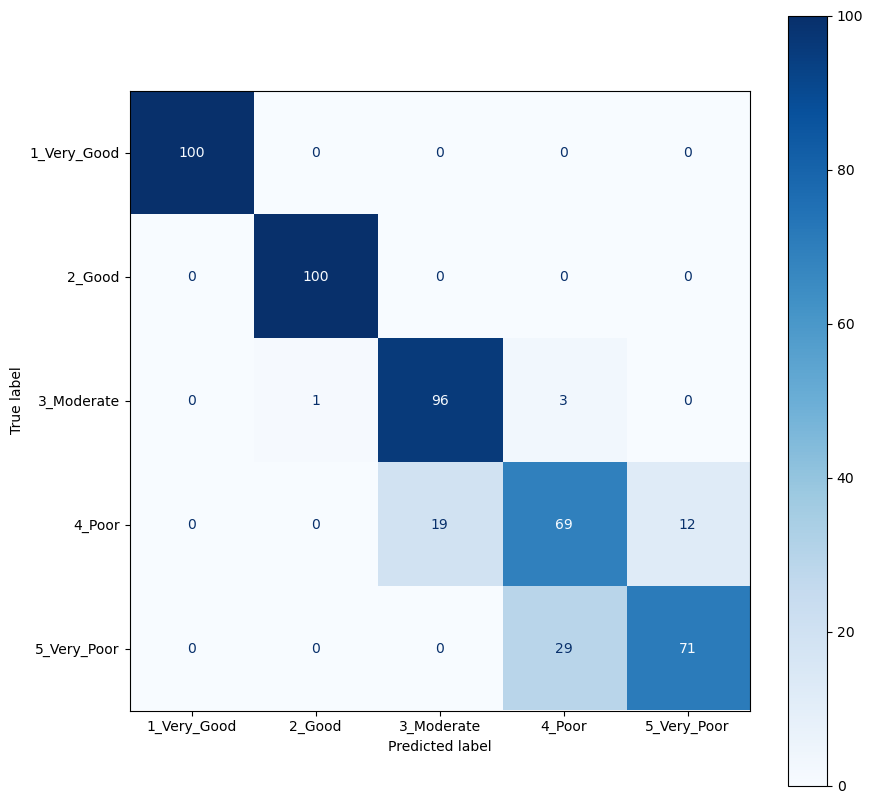

In [14]:
from utils import get_predictions, plot_confusion_matrix

classes = class_names

images, labels, probs = get_predictions(model,test_dataloader,device)
pred_labels = torch.argmax(probs, 1) 
plot_confusion_matrix(labels, pred_labels, classes)
plot_confusion_matrix

In [13]:
models_path = Path('Models/')
model_name = 'ResNet18_1000_class_5_epoch.pth'

save_model(models_path, model_name, model)

model_path = models_path / model_name

loaded_model = ResNet18()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)

loaded_model_results = eval_model(  model=loaded_model,
                                    data_loader=validation_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device = device)
loaded_model_results

Saving the model to: Models\ResNet18_1000_class_5_epoch.pth


  0%|          | 0/16 [00:02<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.37785473465919495,
 'model_acc': 86.09375}